<a href="https://colab.research.google.com/github/BBotond03/NASA_Space_Apps_Challenge_BHAF/blob/main/STA_LTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install PyWavelets

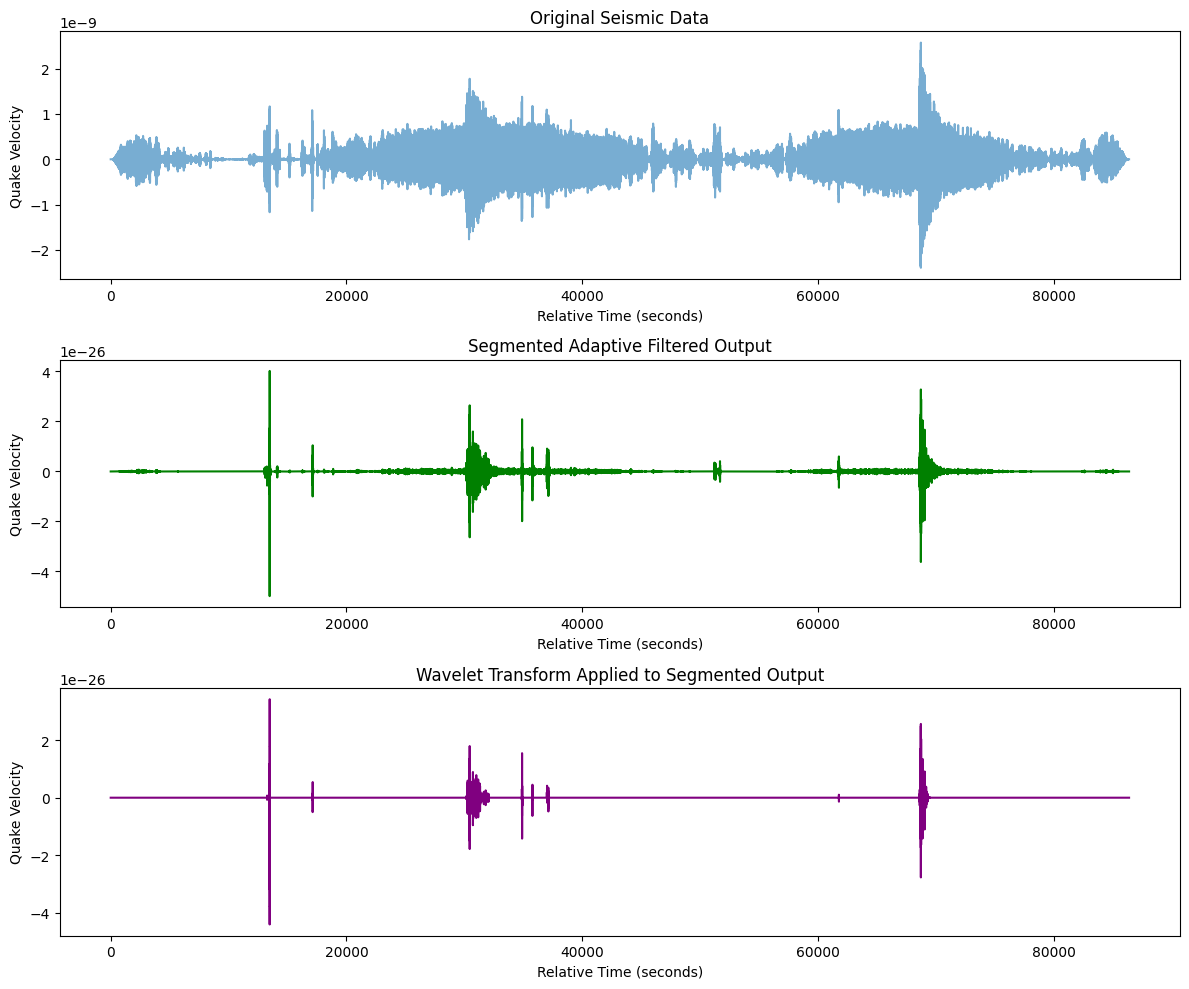

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import pywt
# Importing the PyWavelets library for wavelet transform

# Try reading it as a CSV
df = pd.read_csv('seismic_data.csv')  # Your existing data

# Drop the AbsoluteTime column, keep only relative time and velocity
df = df[["time_rel(sec)", "velocity(m/s)"]]

# Convert to numpy array for easier processing
data = df.to_numpy()

# Extract relative times and velocities
relative_times = data[:, 0]  # Relative time in seconds (starts from 0.0, increases with time)
velocities = data[:, 1]  # Quake velocity

### Adaptive LMS Filter Function ###
def lms_adaptive_filter(input_signal, desired_signal, mu=0.01, filter_order=32):
    """
    Apply LMS adaptive filtering.

    input_signal: The input (noisy) signal.
    desired_signal: The clean signal (reference).
    mu: Step size for LMS algorithm.
    filter_order: Number of coefficients in the filter.
    """
    # Initialize filter coefficients
    w = np.zeros(filter_order)
    # Initialize output and error signals
    output_signal = np.zeros(len(input_signal))
    error_signal = np.zeros(len(input_signal))

    # Apply the LMS algorithm
    for n in range(filter_order, len(input_signal)):
        # Extract the current input vector
        x_n = input_signal[n-filter_order:n]
        # Calculate the output of the adaptive filter
        output_signal[n] = np.dot(w, x_n)
        # Calculate the error
        error_signal[n] = desired_signal[n] - output_signal[n]
        # Update the filter coefficients
        w += mu * error_signal[n] * x_n

    return output_signal, error_signal

### Apply the LMS adaptive filter in segments ###
def apply_filter_in_segments(velocities, segment_size=0.01):
    num_segments = int(np.ceil(len(velocities) * segment_size))
    filtered_output = np.zeros_like(velocities)

    # Iterate through the segments
    for i in range(num_segments):
        start_index = int(i * len(velocities) / num_segments)
        end_index = int((i + 1) * len(velocities) / num_segments)

        # Extract the segment
        segment = velocities[start_index:end_index]

        # Create a desired signal using median filter for this segment
        desired_signal_segment = medfilt(segment, kernel_size=3)

        # Apply the LMS adaptive filter to this segment
        filtered_segment, _ = lms_adaptive_filter(segment, desired_signal_segment)

        # Store the filtered output
        filtered_output[start_index:end_index] = filtered_segment

    return filtered_output

### Wavelet Transform Filtering Function ###
def wavelet_filter(data, wavelet='haar', level=3, threshold=0.2):
    """
    Apply wavelet transform filtering to the input data.

    Parameters:
    - data: Input data array (1D).
    - wavelet: The type of wavelet to use (default is 'haar').
    - level: The level of decomposition (default is 1).
    - threshold: The threshold for wavelet coefficients (default is 0.1).

    Returns:
    - filtered: Wavelet filtered data.
    """
    # Perform the discrete wavelet transform
    coeffs = pywt.wavedec(data, wavelet, level=level)

    # Apply thresholding to the coefficients
    coeffs_thresholded = [pywt.threshold(c, threshold * np.max(np.abs(c)), mode='soft') for c in coeffs]

    # Reconstruct the signal using the thresholded coefficients
    filtered = pywt.waverec(coeffs_thresholded, wavelet)

    # Adjust length to match original data
    if len(filtered) > len(data):
        return filtered[:len(data)]
    elif len(filtered) < len(data):
        return np.pad(filtered, (0, len(data) - len(filtered)), mode='constant')

    return filtered

# Apply the adaptive filter in segments
filtered_output_segments = apply_filter_in_segments(velocities, segment_size=0.001)

# Apply the Wavelet Transform filter on the segmented adaptive filtered output
wavelet_filtered_output = wavelet_filter(filtered_output_segments, wavelet='haar', level=2, threshold=0.1)

### Plotting the Results ###
plt.figure(figsize=(12, 10))

# Original Data
plt.subplot(3, 1, 1)
plt.plot(df["time_rel(sec)"], velocities, label="Original Data", alpha=0.6)
plt.title("Original Seismic Data")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

# Filtered Output (Segmented Adaptive Filter)
plt.subplot(3, 1, 2)
plt.plot(df["time_rel(sec)"], filtered_output_segments, label="Filtered Output (Segmented LMS)", color='green')
plt.title("Segmented Adaptive Filtered Output")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

# Final Wavelet Filtered Output
plt.subplot(3, 1, 3)
plt.plot(df["time_rel(sec)"], wavelet_filtered_output, label="Wavelet Filtered Output", color='purple')
plt.title("Wavelet Transform Applied to Segmented Output")
plt.xlabel("Relative Time (seconds)")
plt.ylabel("Quake Velocity")

plt.tight_layout()
plt.show()

In [17]:
import numpy as np

def sta_lta_detect_event_start(data, nsta, nlta, threshold, quiet_time):
    """
    STA/LTA algorithm for detecting the start of seismic events.

    Parameters:
    - data: 1D numpy array of velocity values.
    - nsta: Window size for STA (short-term average).
    - nlta: Window size for LTA (long-term average).
    - threshold: The STA/LTA threshold for event detection.
    - quiet_time: Minimum number of samples between consecutive events to avoid duplicate detections.

    Returns:
    - event_starts: List of indices marking the start of seismic events.
    - sta_values: Array of STA values.
    - lta_values: Array of LTA values.
    - ratio: Array of STA/LTA ratio.
    """
    # Ensure data is a numpy array
    #data = np.asarray(data)

    # Initialize STA, LTA, and ratio arrays
    sta_values = np.zeros(len(data))
    lta_values = np.zeros(len(data))
    ratio = np.zeros(len(data))

    # List to hold the start of detected seismic events
    event_starts = []

    # Variable to hold the time of the last detected event
    last_event_index = -quiet_time  # Initialize to negative to allow detection at the beginning

    # Start the loop after the LTA window
    for i in range(nlta, len(data)):
        # Calculate the STA and LTA
        sta_values[i] = np.mean(data[i - nsta:i])
        lta_values[i] = np.mean(data[i - nlta:i])

        # To avoid division by zero, check for non-zero LTA
        if lta_values[i] != 0:
            ratio[i] = sta_values[i] / lta_values[i]
        else:
            ratio[i] = 0

        # Check if the STA/LTA ratio exceeds the threshold
        if ratio[i] > threshold and (i - last_event_index) > quiet_time:
            # Mark the start of a seismic event
            event_starts.append(i)
            last_event_index = i  # Update the last event index

    return event_starts, sta_values, lta_values, ratio

# Example usage:
velocity_data = wavelet_filtered_output

# STA and LTA window sizes (in samples)
nsta = 10   # Short-term window
nlta = 1000  # Long-term window
threshold = 3  # Threshold for event detection
quiet_time = 300  # Minimum quiet time between events to avoid false multiple detections

# Run STA/LTA
event_starts, sta, lta, ratio = sta_lta_detect_event_start(velocity_data, nsta, nlta, threshold, quiet_time)

print(f"Seismic events detected at start indices: {event_starts}")

Seismic events detected at start indices: [87901, 89133, 113269, 113572, 199749, 200301, 200602, 201237, 201538, 202215, 202516, 202883, 203187, 203489, 203790, 204107, 204409, 204719, 205021, 205349, 205650, 206185, 206543, 207321, 207623, 208387, 208688, 209369, 209745, 210537, 211669, 212359, 231073, 237029, 245141, 245964, 409309, 454739, 455041, 455342, 455942, 456248, 456962, 457263, 458090, 458395, 459209, 459519, 460463]


In [18]:
def kmeans_1d(data, k=2, max_iters=100):
    """
    Simple K-means algorithm for 1D data with two clusters (k=2).

    Parameters:
    - data: 1D numpy array of input data.
    - k: Number of clusters (default is 2).
    - max_iters: Maximum number of iterations for the K-means algorithm.

    Returns:
    - clusters: A list of arrays where each array contains the data points for one cluster.
    - centroids: Final centroids of the clusters.
    - labels: A list of labels for each data point (0 or 1 indicating the cluster assignment).
    """
    # Ensure data is a numpy array
    data = np.asarray(data)

    # Randomly initialize the centroids by selecting two points from the data
    centroids = np.random.choice(data, k, replace=False)

    # To store the cluster assignment for each point
    labels = np.zeros(len(data), dtype=int)

    for _ in range(max_iters):
        # Assign each point to the closest centroid
        for i, point in enumerate(data):
            distances = np.abs(point - centroids)
            labels[i] = np.argmin(distances)  # 0 or 1 depending on the closest centroid

        # Update the centroids by taking the mean of the points assigned to each cluster
        new_centroids = np.array([data[labels == i].mean() if len(data[labels == i]) > 0 else centroids[i] for i in range(k)])

        # Check for convergence (if centroids don't change, break the loop)
        if np.all(new_centroids == centroids):
            break
        centroids = new_centroids

    # Create clusters based on final labels
    clusters = [data[labels == i] for i in range(k)]



    return clusters, centroids, labels

# Example usage:
data = event_starts

# Run K-means algorithm for 1D data
clusters, centroids, labels = kmeans_1d(data, k=2)

cluster_length = len(clusters[0])
main_cluster = 0
for i in range(len(clusters)):
  if len(clusters[i]) > cluster_length:
    cluster_length = len(clusters[i])
    main_cluster = i



print("Cluster 1:", clusters[0])
print("Cluster 2:", clusters[1])
print(main_cluster)
print("Main Cluster:", clusters[main_cluster])
print("Centroids:", clusters[main_cluster])
print("Labels:", labels)  # Shows which points belong to which cluster

Cluster 1: [409309 454739 455041 455342 455942 456248 456962 457263 458090 458395
 459209 459519 460463]
Cluster 2: [ 87901  89133 113269 113572 199749 200301 200602 201237 201538 202215
 202516 202883 203187 203489 203790 204107 204409 204719 205021 205349
 205650 206185 206543 207321 207623 208387 208688 209369 209745 210537
 211669 212359 231073 237029 245141 245964]
1
Main Cluster: [ 87901  89133 113269 113572 199749 200301 200602 201237 201538 202215
 202516 202883 203187 203489 203790 204107 204409 204719 205021 205349
 205650 206185 206543 207321 207623 208387 208688 209369 209745 210537
 211669 212359 231073 237029 245141 245964]
Centroids: [ 87901  89133 113269 113572 199749 200301 200602 201237 201538 202215
 202516 202883 203187 203489 203790 204107 204409 204719 205021 205349
 205650 206185 206543 207321 207623 208387 208688 209369 209745 210537
 211669 212359 231073 237029 245141 245964]
Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 

In [14]:
print("Start of seismic event at: " + str(centroids[main_cluster]))

Start of seismic event at: 198149.06578947368
